# League of Legends EDA (Exploratory Data Analysis)

## *Michael Han*

# Analyzing League of Legends Ranked Data Given a Summoner Name


## *Part 1: Data Mapping FROM JSON Files*
### - creating mapping dictionaries for the json files to be used to clean match history

## *Part 2: Getting Data from Riot API*
### - creating function to extract match detail
### - using the function to get match history of the top 100 Challengers in North America (webscraped)

## *Part 3: Using Pandas, Numpy, Matplotlib, and Seaborn to analyze the cleaned data*
### - general EDA (Exploratory Data Analysis) through answering questions about the data through creating summary tables and visualizations

## *Part 1: Data Mapping From JSON Files*
### Step 1: Get all required information from the JSON files provided through json files provided by Data Dragon throgh the docs in Riot API Website
### Step 2:Create Mapping Dictionaries to map the corresponding champions, items, summoner spells, and season to each corresponding key

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import regex as re
import json
import time
from bs4 import BeautifulSoup

### Champion File

In [653]:
with open("Data_Files/champion.json", encoding = "utf-8") as f:
    champion_data = json.load(f)

In [654]:
champion_key_dict = {}

for champion, info in champion_data["data"].items():
    champion_name = champion
    for champ_key, key_value in info.items():
        if champ_key == "key":
            champion_key_dict[champion_name] = key_value
        else:
            pass

In [655]:
champion_key_dict = {int(y):x for x,y in champion_key_dict.items()}

### Item File

In [656]:
# reading in json file
with open("Data_Files/item.json", encoding = "utf-8") as f:
    item_data = json.load(f)

In [657]:
item_key_dict = {}

for item, info in item_data["data"].items():
    item_id = item
    for item_key, item_value in info.items():
        if item_key == "name":
            item_key_dict[int(item_id)] = item_value
        else:
            pass

### Queue Type File

In [658]:
with open("Data_Files/queue_type.json", encoding = "utf-8") as f:
    queue_data = json.load(f)

In [659]:
queue_info_dict = {}

for queue in queue_data:
    for q_key, q_value in queue.items():
        if q_key == "queueId":
            queue_key = q_value
            queue_description = queue["description"]
            queue_notes = queue["notes"]
            queue_info_dict[queue_key] = [queue_description, queue_notes]
        else:
            pass

### Summoner Spell File

In [660]:
with open("Data_Files/summoner_spell.json", encoding = "utf-8") as f:
    ss_data = json.load(f)

In [661]:
ss_key_dict = {}

for spell, info in ss_data["data"].items():
    for ss_key in info:
        ss_name = info["name"]
        ss_key = info["key"]
        ss_key_dict[ss_name] = ss_key

In [662]:
ss_key_dict = {int(y):x for x,y in ss_key_dict.items()}

### Season File

In [663]:
with open("Data_Files/season_info.json", encoding = "utf-8") as f:
    season_data = json.load(f)

In [664]:
season_info_dict = {}
for season in season_data:
    season_id = season["id"]
    season_name = season["season"]
    season_info_dict[season_id] = season_name

## *Part 2: Getting Data from Riot API*
### Step 1: Get Account Information - SUMMONER-V4
### Step 2: Get Game ID Through MATCH-V4
### Step 3: Get Match Data through using GameID from MATCH-V4
### Step 4: Create Super Function
### Step 5: Webscrape top 100 Challenger Summoner Names
### step 6: Run Through the top 100 Summoner Names and extract match history data

### *Step 1*

In [1]:
riot_headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.66 Safari/537.36",
    "Accept-Language": "en-US,en;q=0.9",
    "Accept-Charset": "application/x-www-form-urlencoded; charset=UTF-8",
    "Origin": "https://developer.riotgames.com",
    "X-Riot-Token": ""
    }
riot_api = ""
def get_account_id(summoner_name, riot_api_key, riot_headers):
    summoner_name = summoner_name.replace(" ", "%20")
    url = "https://na1.api.riotgames.com/lol/summoner/v4/summoners/by-name/"
    account_url = url + summoner_name
    riot_headers = riot_headers
    riot_headers["X-Riot-Token"] = riot_api_key
    req = requests.get(account_url, headers = riot_headers)
    if req.status_code == 200:
        account_info = json.loads(req.content.decode("utf-8"))
        account_id = account_info["accountId"]
        return account_id
    elif req.status_code == 429:
        while True:
            req = requests.get(account_url, headers = riot_headers)
            if req.status_code == 200:
                account_info = json.loads(req.content.decode("utf-8"))
                account_id = account_info["accountId"]
                return account_id
                break
            elif req.status_code == 429:
                time.sleep(5)

### *Step 2*

In [16]:
def get_match_history(account_id, riot_api_key, riot_headers):
    account_id = account_id
    match_history_url = "https://na1.api.riotgames.com/lol/match/v4/matchlists/by-account/" + str(account_id)
    riot_headers = riot_headers
    
    riot_headers["X-Riot-Token"] = riot_api_key
    req = requests.get(match_history_url, headers = riot_headers)
    if req.status_code == 200:
        match_history = json.loads(req.content.decode("utf-8"))
        return match_history
    elif req.status_code == 429:
        while True:
            req = requests.get(match_history_url, headers = riot_headers)
            if req.status_code == 200:
                match_history = json.loads(req.content.decode("utf-8"))
                return match_history
                break
            elif req.status_code == 429:
                time.sleep(5)
    else:
        return "No Match History Available"

In [17]:
def get_game_id(match_history_dict):
    game_id_list = []
    for game_description in match_history_dict["matches"]:
        game_id = str(game_description["gameId"])
        queue_id = game_description["queue"]
        if queue_id in [420, 440]:
            game_id_list.append(game_id)
    return game_id_list

### *Step 3*

In [18]:
def get_match_urls(game_id_list):
    match_detail_url_template = "https://na1.api.riotgames.com/lol/match/v4/matches/"
    match_detail_url_list = []
    for game_id in game_id_list:
        game_id_url = match_detail_url_template + game_id
        match_detail_url_list.append(game_id_url)
    return match_detail_url_list

In [19]:
def get_match_data(match_detail_url_list, riot_api_key, riot_headers):
    riot_headers = riot_headers
    riot_headers["X-Riot-Token"] = riot_api_key
    match_detail_data = {}
    
    for match_url in match_detail_url_list:
        req = requests.get(match_url, headers = riot_headers)
        
        if req.status_code == 200:
            match_detail = json.loads(req.content.decode("utf-8"))
            match_detail_data.setdefault(match_url[-10:], []).append(match_detail)
            
        elif req.status_code == 429:
            while True:
                req = requests.get(match_url, headers = riot_headers)
                if req.status_code == 200:
                    match_detail = json.loads(req.content.decode("utf-8"))
                    match_detail_data.setdefault(match_url[-10:], []).append(match_detail)
                    break
                elif req.status_code == 429:
                    time.sleep(5)
                    
    return match_detail_data

In [20]:
# get username information
# 1. figure out what participant id username is linked too

In [21]:
def get_match_data_in_two_lists(match_detail_data):
    summoners_match_data_detail = []
    summoners_name_list = []
    for match_id, matches_details in match_detail_data.items():
        for match in matches_details:
            for outer_key, outer_value in match.items():
            
                if outer_key == "gameId":
                    game_id = outer_value
                
                if outer_key == "participants":
                
                    for participant in outer_value:
                    
                        for p_key in participant:
                            participant_id = participant["participantId"]
                            team_id = participant["teamId"]
                            champion_id = participant["championId"]
                            spell_one = participant["spell1Id"]
                            spell_two = participant["spell2Id"]
                            stats = participant["stats"]
                        
                            summoner_match_data = {
                                "game ID": game_id,
                                "participant ID": participant_id,
                                "team ID": team_id,
                                "champion ID": champion_id,
                                "Summoner Spell One": spell_one,
                                "Summoner Spell Two": spell_two,
                                "Statistics": stats
                                }
                        summoners_match_data_detail.append(summoner_match_data)
                    
                    
                if outer_key == "participantIdentities":
                    for participant in outer_value:
                        for p_key, p_value in participant["player"].items():
                            if p_key == "summonerName":
                                summoner_name = p_value
                                summoners_name_list.append(summoner_name)
                                
    return summoners_match_data_detail, summoners_name_list

In [22]:
def get_match_data_info_into_df(summoners_match_data_detail, summoners_name_list):
    game_data = pd.DataFrame(summoners_match_data_detail)
    statistics  = dict(game_data["Statistics"])
    statistics_df = pd.DataFrame(statistics).transpose()
    df = pd.concat([game_data, statistics_df], axis = 1)
    df = df.drop(columns = ["Statistics", "participantId"])
    df_cols = ['game ID',
                     'participant ID',
                     'Summoner Name',
                     'team ID',
                     'champion ID',
                     'Summoner Spell One',
                     'Summoner Spell Two',
                     'win',
                     'item0',
                     'item1',
                     'item2',
                     'item3',
                     'item4',
                     'item5',
                     'item6',
                     'kills',
                     'deaths',
                     'assists',
                     'largestKillingSpree',
                     'largestMultiKill',
                     'killingSprees',
                     'longestTimeSpentLiving',
                     'doubleKills',
                     'tripleKills',
                     'quadraKills',
                     'pentaKills',
                     'unrealKills',
                     'totalDamageDealt',
                     'magicDamageDealt',
                     'physicalDamageDealt',
                     'trueDamageDealt',
                     'largestCriticalStrike',
                     'totalDamageDealtToChampions',
                     'magicDamageDealtToChampions',
                     'physicalDamageDealtToChampions',
                     'trueDamageDealtToChampions',
                     'totalHeal',
                     'totalUnitsHealed',
                     'damageSelfMitigated',
                     'damageDealtToObjectives',
                     'damageDealtToTurrets',
                     'visionScore',
                     'timeCCingOthers',
                     'totalDamageTaken',
                     'magicalDamageTaken',
                     'physicalDamageTaken',
                     'trueDamageTaken',
                     'goldEarned',
                     'goldSpent',
                     'turretKills',
                     'inhibitorKills',
                     'totalMinionsKilled',
                     'neutralMinionsKilled',
                     'neutralMinionsKilledTeamJungle',
                     'neutralMinionsKilledEnemyJungle',
                     'totalTimeCrowdControlDealt',
                     'champLevel',
                     'visionWardsBoughtInGame',
                     'sightWardsBoughtInGame',
                     'wardsPlaced',
                     'wardsKilled',
                     'firstBloodKill',
                     'firstBloodAssist',
                     'firstTowerKill',
                     'firstTowerAssist',
                     'firstInhibitorKill',
                     'firstInhibitorAssist']
    summoners_series = pd.Series(summoners_name_list)
    df.insert(2, "Summoner Name", summoners_series)
    df = df[df_cols]
    
    return df

In [23]:
def map_df_ids(df):
    
    df["Summoner Spell One"] = df["Summoner Spell One"].map(ss_key_dict)
    df["Summoner Spell Two"] = df["Summoner Spell Two"].map(ss_key_dict)
    df["champion ID"] = df["champion ID"].map(champion_key_dict)
    item_columns = ["item0", "item1", "item2", "item3", "item4", "item5", "item6"]
    for col in item_columns:
        df[col] = df[col].map(item_key_dict)
    return df

### *Step 4*

In [24]:
def get_summoner_match_data(summoner_name):
    riot_headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.66 Safari/537.36",
    "Accept-Language": "en-US,en;q=0.9",
    "Accept-Charset": "application/x-www-form-urlencoded; charset=UTF-8",
    "Origin": "https://developer.riotgames.com",
    "X-Riot-Token": ""
    }
    riot_api = "RGAPI-712935da-94c4-4072-8a05-2d11b1f4a185"

    summoner_account_id = get_account_id(summoner_name, riot_api, riot_headers)
  
    summoner_match_history = get_match_history(summoner_account_id, riot_api, riot_headers)
    
    if type(summoner_match_history) == str:
        return f"No Data Available for {summoner_name} in this season"
  
    else:
        summoner_game_id_list = get_game_id(summoner_match_history)
    
        if summoner_game_id_list == []:
        
            return f"No Ranked Games for {summoner_name} in this season"
    
        else:
        
            summoner_game_url_list = get_match_urls(summoner_game_id_list)
    
            match_detail_data = get_match_data(summoner_game_url_list, riot_api, riot_headers)
    
            summoners_match_data_and_summoner_names = get_match_data_in_two_lists(match_detail_data)

            df = get_match_data_info_into_df(summoners_match_data_detail = summoners_match_data_and_summoner_names[0], 
                                         summoners_name_list = summoners_match_data_and_summoner_names[1])

            df = map_df_ids(df)
            df = df.loc[df["Summoner Name"] == summoner_name, :]
    
            return df

### *Step 5*
#### - looking at the match history of the top 100 Challengers in NA Region as of 12/09/2020
#### - note that right now is preseason - out of the top 100 Challengers some have not played in preseason

In [676]:
url = "https://na.op.gg/ranking/ladder/"
response = requests.get(url);

In [677]:
html_soup = BeautifulSoup(response.text, "html.parser")
html_soup;

In [27]:
challenger_top_one_hundred = []

chall_rankings_top_four = html_soup.find_all("li", class_ = "ranking-highest__item")
for chall_ranking in chall_rankings_top_four:
    chall_summoner_name = chall_ranking.find("a", class_ = "ranking-highest__name").text
    challenger_top_one_hundred.append(chall_summoner_name)

In [28]:
chall_rankings_rest = html_soup.find_all("tr", class_ = "ranking-table__row")

for chall_ranking in chall_rankings_rest:
    challenger_top_one_hundred.append(chall_ranking.a.text)

In [29]:
challenger_top_one_hundred

['Revenge',
 'LAFLAMME 01',
 'First Kyu',
 'hate it here',
 'Yunbee2',
 '5fire',
 'CtrI C',
 'PantsAreFacebook',
 'qpalzmwoiaj',
 'John5un',
 'adc nme',
 'KEITH EXOTIC',
 'Spawwwwn',
 'jojopyun 16',
 'OSHMKUFA',
 'Breezyyy1',
 '10 iQ PLAYER',
 'Winter',
 'Throw',
 '100 Kenvi',
 'AnDa',
 'TwitchTv Revenge',
 'SHEIDEN99',
 'Cody Sun',
 'Viber',
 'Vakin2',
 'Sheiden',
 '100 Tenacity',
 '100 Closer',
 'Giyuu9',
 'TSM Lost',
 'Hyami LFT',
 'Ràsberry',
 'Pants are Dragon',
 'CHlME',
 'GibIe',
 'Uma Jan pupil',
 'Went',
 'dopamine detox1',
 'SRTTY VS AMERICA',
 'Smoothie',
 'Niles',
 'Tony Top',
 'Dhokla',
 'Ina',
 'ONETRICKPOLICE',
 'Keel7',
 'power1ess',
 'C9 Wixxi',
 'PantsAreYouTube',
 'Spurge',
 'Cxa',
 'Fizzi',
 'A5PECT',
 'tomio diff',
 'lIllIIlIlIlIlI',
 'Bíg T',
 'Neøø',
 'Dragoon',
 'stuntopolis',
 'Copý',
 'Cupic',
 'Draven696969',
 'Yeonn',
 'General Sniper',
 'WayOfTheTempesst',
 'CptShrimps',
 'Rookie Laner',
 'a219',
 'Sordé',
 'Hookś',
 'Repobah',
 '100 PERCENT SLOW',
 'joe ma

In [30]:
len(challenger_top_one_hundred)

100

### *Step 6*
#### - due to the limit on RIOT API requests, I ran the summoner names ten at a time

In [31]:
time.sleep(60)

In [32]:
df_dict = {}
counter = 0
for chall in challenger_top_one_hundred[0:10]:
    df = get_summoner_match_data(chall)
    counter += 1
    print(f"Got data for {counter} out of 100")
    df_dict[chall] = df

Got data for 1 out of 100
Got data for 2 out of 100
Got data for 3 out of 100
Got data for 4 out of 100
Got data for 5 out of 100
Got data for 6 out of 100
Got data for 7 out of 100
Got data for 8 out of 100
Got data for 9 out of 100
Got data for 10 out of 100


In [33]:
time.sleep(120)

In [34]:
for chall in challenger_top_one_hundred[10:20]:
    df = get_summoner_match_data(chall)
    counter += 1
    print(f"Got data for {counter} out of 100")
    df_dict[chall] = df

Got data for 11 out of 100
Got data for 12 out of 100
Got data for 13 out of 100
Got data for 14 out of 100
Got data for 15 out of 100
Got data for 16 out of 100
Got data for 17 out of 100
Got data for 18 out of 100
Got data for 19 out of 100
Got data for 20 out of 100


In [35]:
time.sleep(120)

In [36]:
for chall in challenger_top_one_hundred[20:30]:
    df = get_summoner_match_data(chall)
    counter += 1
    print(f"Got data for {counter} out of 100")
    df_dict[chall] = df

Got data for 21 out of 100
Got data for 22 out of 100
Got data for 23 out of 100
Got data for 24 out of 100
Got data for 25 out of 100
Got data for 26 out of 100
Got data for 27 out of 100
Got data for 28 out of 100
Got data for 29 out of 100
Got data for 30 out of 100


In [37]:
time.sleep(120)

In [38]:
for chall in challenger_top_one_hundred[30:40]:
    df = get_summoner_match_data(chall)
    counter += 1
    print(f"Got data for {counter} out of 100")
    df_dict[chall] = df

Got data for 31 out of 100
Got data for 32 out of 100
Got data for 33 out of 100
Got data for 34 out of 100
Got data for 35 out of 100
Got data for 36 out of 100
Got data for 37 out of 100
Got data for 38 out of 100
Got data for 39 out of 100
Got data for 40 out of 100


In [39]:
time.sleep(120)

In [40]:
for chall in challenger_top_one_hundred[40:50]:
    df = get_summoner_match_data(chall)
    counter += 1
    print(f"Got data for {counter} out of 100")
    df_dict[chall] = df

Got data for 41 out of 100
Got data for 42 out of 100
Got data for 43 out of 100
Got data for 44 out of 100
Got data for 45 out of 100
Got data for 46 out of 100
Got data for 47 out of 100
Got data for 48 out of 100
Got data for 49 out of 100
Got data for 50 out of 100


In [41]:
time.sleep(120)

In [42]:
for chall in challenger_top_one_hundred[50:60]:
    df = get_summoner_match_data(chall)
    counter += 1
    print(f"Got data for {counter} out of 100")
    df_dict[chall] = df

Got data for 51 out of 100
Got data for 52 out of 100
Got data for 53 out of 100
Got data for 54 out of 100
Got data for 55 out of 100
Got data for 56 out of 100
Got data for 57 out of 100
Got data for 58 out of 100
Got data for 59 out of 100
Got data for 60 out of 100


In [43]:
time.sleep(120)

In [44]:
for chall in challenger_top_one_hundred[60:70]:
    df = get_summoner_match_data(chall)
    counter += 1
    print(f"Got data for {counter} out of 100")
    df_dict[chall] = df

Got data for 61 out of 100
Got data for 62 out of 100
Got data for 63 out of 100
Got data for 64 out of 100
Got data for 65 out of 100
Got data for 66 out of 100
Got data for 67 out of 100
Got data for 68 out of 100
Got data for 69 out of 100
Got data for 70 out of 100


In [45]:
time.sleep(120)

In [46]:
for chall in challenger_top_one_hundred[70:80]:
    df = get_summoner_match_data(chall)
    counter += 1
    print(f"Got data for {counter} out of 100")
    df_dict[chall] = df

Got data for 71 out of 100
Got data for 72 out of 100
Got data for 73 out of 100
Got data for 74 out of 100
Got data for 75 out of 100
Got data for 76 out of 100
Got data for 77 out of 100
Got data for 78 out of 100
Got data for 79 out of 100
Got data for 80 out of 100


In [47]:
time.sleep(120)

In [48]:
for chall in challenger_top_one_hundred[80:90]:
    df = get_summoner_match_data(chall)
    counter += 1
    print(f"Got data for {counter} out of 100")
    df_dict[chall] = df

Got data for 81 out of 100
Got data for 82 out of 100
Got data for 83 out of 100
Got data for 84 out of 100
Got data for 85 out of 100
Got data for 86 out of 100
Got data for 87 out of 100
Got data for 88 out of 100
Got data for 89 out of 100
Got data for 90 out of 100


In [49]:
time.sleep(120)

In [50]:
for chall in challenger_top_one_hundred[90:]:
    df = get_summoner_match_data(chall)
    counter += 1
    print(f"Got data for {counter} out of 100")
    df_dict[chall] = df

Got data for 91 out of 100
Got data for 92 out of 100
Got data for 93 out of 100
Got data for 94 out of 100
Got data for 95 out of 100
Got data for 96 out of 100
Got data for 97 out of 100
Got data for 98 out of 100
Got data for 99 out of 100
Got data for 100 out of 100


In [51]:
match_history_df = pd.concat([df for df in df_dict.values() if type(df) == pd.core.frame.DataFrame], ignore_index = True)
match_history_df

,game ID,participant ID,Summoner Name,team ID,champion ID,Summoner Spell One,Summoner Spell Two,win,item0,item1,item2,item3,item4,item5,item6,kills,deaths,assists,largestKillingSpree,largestMultiKill,killingSprees,longestTimeSpentLiving,doubleKills,tripleKills,quadraKills,pentaKills,unrealKills,totalDamageDealt,magicDamageDealt,physicalDamageDealt,trueDamageDealt,largestCriticalStrike,totalDamageDealtToChampions,magicDamageDealtToChampions,physicalDamageDealtToChampions,trueDamageDealtToChampions,totalHeal,totalUnitsHealed,damageSelfMitigated,damageDealtToObjectives,damageDealtToTurrets,visionScore,timeCCingOthers,totalDamageTaken,magicalDamageTaken,physicalDamageTaken,trueDamageTaken,goldEarned,goldSpent,turretKills,inhibitorKills,totalMinionsKilled,neutralMinionsKilled,neutralMinionsKilledTeamJungle,neutralMinionsKilledEnemyJungle,totalTimeCrowdControlDealt,champLevel,visionWardsBoughtInGame,sightWardsBoughtInGame,wardsPlaced,wardsKilled,firstBloodKill,firstBloodAssist,firstTowerKill,firstTowerAssist,firstInhibitorKill,firstInhibitorAssist
0,3695694946,8,Revenge,200,Vayne,Heal,Flash,True,Doran's Blade,Guinsoo's Rageblade,Control Ward,Kraken Slayer,Vampiric Scepter,Berserker's Greaves,Stealth Ward,8,2,3,4,2,2,391,1,0,0,0,0,75703,0,62649,13054,274,13126,0,10147,2979,5489,2,3728,5498,4382,5,6,9898,1070,8514,314,9685,9025,2,0,136,8,0,5,99,10,1,0,3,1,False,False,True,False,NaN,NaN
1,3695606219,6,Revenge,200,Yone,Exhaust,Flash,True,Kraken Slayer,Bloodthirster,Vampiric Scepter,Lord Dominik's Regards,Berserker's Greaves,Sterak's Gage,Farsight Alteration,12,8,4,4,2,3,597,2,0,0,0,0,292149,31963,235316,24868,662,38995,5821,23591,9581,9583,1,39284,23579,5458,27,47,29090,8711,20002,376,18322,16155,2,0,264,42,23,0,262,17,2,0,8,4,True,False,False,False,False,True
2,3695104537,6,Revenge,200,Fiora,Teleport,Flash,True,Ravenous Hydra,Trinity Force,Guardian Angel,Muramana,Plated Steelcaps,Death's Dance,Farsight Alteration,12,5,10,4,2,3,866,2,0,0,0,0,264285,2046,232615,29623,867,35951,1152,26829,7969,20718,5,37848,16957,11135,34,13,36055,10661,21644,3749,18578,17608,5,1,296,32,12,9,227,18,3,0,11,9,False,False,True,False,True,False
3,3694718495,9,Revenge,200,Viktor,Teleport,Flash,True,Mejai's Soulstealer,Liandry's Anguish,Lich Bane,Needlessly Large Rod,Ionian Boots of Lucidity,Needlessly Large Rod,Stealth Ward,10,5,10,5,3,2,569,2,1,0,0,0,128073,113128,14039,905,0,29451,28546,826,78,4980,1,17111,6910,2469,16,18,17832,5138,11394,1300,12965,12000,2,0,178,24,8,9,277,15,0,0,7,3,False,False,False,False,False,True
4,3680952570,7,Revenge,200,Zac,Teleport,Flash,False,Spirit Visage,Sunfire Aegis,NaN,Thornmail,Demonic Embrace,Plated Steelcaps,Oracle Lens,12,10,16,4,2,2,375,1,0,0,0,0,135362,120928,12486,1948,18,41148,38422,2417,308,48483,1,50735,6611,652,12,70,58036,15809,34653,7574,14732,13775,1,0,126,16,4,1,382,16,1,0,7,1,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5612,3653181712,2,Bejjaniii,100,Riven,Teleport,Flash,True,Randuin's Omen,NaN,Black Cleaver,Executioner's Calling,Cloth Armor,Slightly Magical Footwear,Oracle Lens,12,4,4,5,3,3,396,1,1,0,0,0,121311,125,120748,438,0,17454,125,17119,210,4492,1,22008,6485,5384,21,28,14976,2301,9900,2774,12537,10950,4,1,168,11,0,9,189,15,2,0,8,4,True,False,True,False,False,False
5613,3653160036,3,Bejjaniii,100,Riven,Teleport,Flash,True,Black Cleaver,Guardian Angel,Edge of Night,Plated Steelcaps,Mortal Reminder,NaN,Oracle Lens,9,5,9,7,2,2,445,1,0,0,0,0,223455,0,219392,4063,0,23405,0,23132,273,9635,1,33740,5592,3949,33,33,27215,9238,11424,6552,18314,16975,1,0,261,8,4,4,190,18,3,0,13,4,False,False,False,False,False,False
5614,3653077309,5,Bejjaniii,100,Riven,Ignite,Flash,False,Caulfield's Warhammer,Kindlegem,Plated Steelcaps,Phage,Long Sword,NaN,Oracle Lens,2,3

In [52]:
match_history_df.shape

(5617, 67)

In [53]:
match_history_df.to_csv(r"C:\Users\newsp\Desktop\Python_Study_Nov\Data_Science_Python\Python_Projects\Data_Files\top_100_challenger_match_detail3.csv", sep = ",", header = True, index = False)

## *Part 3* 
### Exporing Match History of top 100 Challengers in NA during preseason

In [598]:
match_df = pd.read_csv(r"Data_Files\top_100_challenger_match_detail3.csv", sep = ",")

In [599]:
match_df.head()

,game ID,participant ID,Summoner Name,team ID,champion ID,Summoner Spell One,Summoner Spell Two,win,item0,item1,item2,item3,item4,item5,item6,kills,deaths,assists,largestKillingSpree,largestMultiKill,killingSprees,longestTimeSpentLiving,doubleKills,tripleKills,quadraKills,pentaKills,unrealKills,totalDamageDealt,magicDamageDealt,physicalDamageDealt,trueDamageDealt,largestCriticalStrike,totalDamageDealtToChampions,magicDamageDealtToChampions,physicalDamageDealtToChampions,trueDamageDealtToChampions,totalHeal,totalUnitsHealed,damageSelfMitigated,damageDealtToObjectives,damageDealtToTurrets,visionScore,timeCCingOthers,totalDamageTaken,magicalDamageTaken,physicalDamageTaken,trueDamageTaken,goldEarned,goldSpent,turretKills,inhibitorKills,totalMinionsKilled,neutralMinionsKilled,neutralMinionsKilledTeamJungle,neutralMinionsKilledEnemyJungle,totalTimeCrowdControlDealt,champLevel,visionWardsBoughtInGame,sightWardsBoughtInGame,wardsPlaced,wardsKilled,firstBloodKill,firstBloodAssist,firstTowerKill,firstTowerAssist,firstInhibitorKill,firstInhibitorAssist
0,3695694946,8,Revenge,200,Vayne,Heal,Flash,True,Doran's Blade,Guinsoo's Rageblade,Control Ward,Kraken Slayer,Vampiric Scepter,Berserker's Greaves,Stealth Ward,8,2,3,4,2,2,391,1,0,0,0,0,75703,0,62649,13054,274,13126,0,10147,2979,5489,2,3728,5498,4382,5,6,9898,1070,8514,314,9685,9025,2,0,136,8,0,5,99,10,1,0,3,1,False,False,True,False,NaN,NaN
1,3695606219,6,Revenge,200,Yone,Exhaust,Flash,True,Kraken Slayer,Bloodthirster,Vampiric Scepter,Lord Dominik's Regards,Berserker's Greaves,Sterak's Gage,Farsight Alteration,12,8,4,4,2,3,597,2,0,0,0,0,292149,31963,235316,24868,662,38995,5821,23591,9581,9583,1,39284,23579,5458,27,47,29090,8711,20002,376,18322,16155,2,0,264,42,23,0,262,17,2,0,8,4,True,False,False,False,False,True
2,3695104537,6,Revenge,200,Fiora,Teleport,Flash,True,Ravenous Hydra,Trinity Force,Guardian Angel,Muramana,Plated Steelcaps,Death's Dance,Farsight Alteration,12,5,10,4,2,3,866,2,0,0,0,0,264285,2046,232615,29623,867,35951,1152,26829,7969,20718,5,37848,16957,11135,34,13,36055,10661,21644,3749,18578,17608,5,1,296,32,12,9,227,18,3,0,11,9,False,False,True,False,True,False
3,3694718495,9,Revenge,200,Viktor,Teleport,Flash,True,Mejai's Soulstealer,Liandry's Anguish,Lich Bane,Needlessly Large Rod,Ionian Boots of Lucidity,Needlessly Large Rod,Stealth Ward,10,5,10,5,3,2,569,2,1,0,0,0,128073,113128,14039,905,0,29451,28546,826,78,4980,1,17111,6910,2469,16,18,17832,5138,11394,1300,12965,12000,2,0,178,24,8,9,277,15,0,0,7,3,False,False,False,False,False,True
4,3680952570,7,Revenge,200,Zac,Teleport,Flash,False,Spirit Visage,Sunfire Aegis,NaN,Thornmail,Demonic Embrace,Plated Steelcaps,Oracle Lens,12,10,16,4,2,2,375,1,0,0,0,0,135362,120928,12486,1948,18,41148,38422,2417,308,48483,1,50735,6611,652,12,70,58036,15809,34653,7574,14732,13775,1,0,126,16,4,1,382,16,1,0,7,1,False,False,False,False,False,False


In [601]:
match_df.rename(columns = {
    "game ID": "gameID",
    "participant ID": "participantID",
    "Summoner Name": "summonerName",
    "team ID": "teamID",
    "champion ID": "championName",
    "Summoner Spell One": "summmonerSpell1",
    "Summoner Spell Two": "summonerSpell2"
    }, inplace = True)

In [602]:
match_df["teamID"] = match_df["teamID"].map({100: "Blue", 200: "Red"})

In [665]:
match_df.head()

,gameID,participantID,summonerName,teamID,championName,summmonerSpell1,summonerSpell2,win,item0,item1,item2,item3,item4,item5,item6,kills,deaths,assists,largestKillingSpree,largestMultiKill,killingSprees,longestTimeSpentLiving,doubleKills,tripleKills,quadraKills,pentaKills,unrealKills,totalDamageDealt,magicDamageDealt,physicalDamageDealt,trueDamageDealt,largestCriticalStrike,totalDamageDealtToChampions,magicDamageDealtToChampions,physicalDamageDealtToChampions,trueDamageDealtToChampions,totalHeal,totalUnitsHealed,damageSelfMitigated,damageDealtToObjectives,damageDealtToTurrets,visionScore,timeCCingOthers,totalDamageTaken,magicalDamageTaken,physicalDamageTaken,trueDamageTaken,goldEarned,goldSpent,turretKills,inhibitorKills,totalMinionsKilled,neutralMinionsKilled,neutralMinionsKilledTeamJungle,neutralMinionsKilledEnemyJungle,totalTimeCrowdControlDealt,champLevel,visionWardsBoughtInGame,sightWardsBoughtInGame,wardsPlaced,wardsKilled,firstBloodKill,firstBloodAssist,firstTowerKill,firstTowerAssist,firstInhibitorKill,firstInhibitorAssist
0,3695694946,8,Revenge,Red,Vayne,Heal,Flash,True,Doran's Blade,Guinsoo's Rageblade,Control Ward,Kraken Slayer,Vampiric Scepter,Berserker's Greaves,Stealth Ward,8,2,3,4,2,2,391,1,0,0,0,0,75703,0,62649,13054,274,13126,0,10147,2979,5489,2,3728,5498,4382,5,6,9898,1070,8514,314,9685,9025,2,0,136,8,0,5,99,10,1,0,3,1,False,False,True,False,NaN,NaN
1,3695606219,6,Revenge,Red,Yone,Exhaust,Flash,True,Kraken Slayer,Bloodthirster,Vampiric Scepter,Lord Dominik's Regards,Berserker's Greaves,Sterak's Gage,Farsight Alteration,12,8,4,4,2,3,597,2,0,0,0,0,292149,31963,235316,24868,662,38995,5821,23591,9581,9583,1,39284,23579,5458,27,47,29090,8711,20002,376,18322,16155,2,0,264,42,23,0,262,17,2,0,8,4,True,False,False,False,False,True
2,3695104537,6,Revenge,Red,Fiora,Teleport,Flash,True,Ravenous Hydra,Trinity Force,Guardian Angel,Muramana,Plated Steelcaps,Death's Dance,Farsight Alteration,12,5,10,4,2,3,866,2,0,0,0,0,264285,2046,232615,29623,867,35951,1152,26829,7969,20718,5,37848,16957,11135,34,13,36055,10661,21644,3749,18578,17608,5,1,296,32,12,9,227,18,3,0,11,9,False,False,True,False,True,False
3,3694718495,9,Revenge,Red,Viktor,Teleport,Flash,True,Mejai's Soulstealer,Liandry's Anguish,Lich Bane,Needlessly Large Rod,Ionian Boots of Lucidity,Needlessly Large Rod,Stealth Ward,10,5,10,5,3,2,569,2,1,0,0,0,128073,113128,14039,905,0,29451,28546,826,78,4980,1,17111,6910,2469,16,18,17832,5138,11394,1300,12965,12000,2,0,178,24,8,9,277,15,0,0,7,3,False,False,False,False,False,True
4,3680952570,7,Revenge,Red,Zac,Teleport,Flash,False,Spirit Visage,Sunfire Aegis,NaN,Thornmail,Demonic Embrace,Plated Steelcaps,Oracle Lens,12,10,16,4,2,2,375,1,0,0,0,0,135362,120928,12486,1948,18,41148,38422,2417,308,48483,1,50735,6611,652,12,70,58036,15809,34653,7574,14732,13775,1,0,126,16,4,1,382,16,1,0,7,1,False,False,False,False,False,False


### 1. Most popular champion in preseason for these top players?

In [604]:
top_ten_champions = pd.DataFrame(match_df["championName"].value_counts().head(10)).reset_index()

In [605]:
top_ten_champions.rename(columns = {"index": "championName", "championName": "championCount"}, inplace = True)

In [606]:
top_ten_champions

,championName,championCount
0,Camille,237
1,Leona,192
2,Lucian,175
3,Akali,157
4,Jhin,157
5,Sylas,155
6,Pantheon,152
7,Graves,139
8,Galio,130
9,Irelia,120


### 2. Highest win rate and played champion in preseason?
#### - to exclude win rates of champions where the count of games is low, the data has been filtered to have the count of games be at least equal to the overall average game count

In [666]:
champion_win_rate = match_df.groupby("championName").agg({"championName": "count", "win": "mean"})

In [667]:
champion_win_rate.rename(columns = {"championName": "championCount","win": "winRatio"}, inplace = True)
champion_win_rate = champion_win_rate.reset_index()

In [668]:
champion_win_rate["championCount"].mean()

39.556338028169016

In [670]:
# filter for count more than or equal to 40
count_morethan40 = champion_win_rate["championCount"] >= 40
champion_win_rate = champion_win_rate.loc[count_morethan40]

In [671]:
top_ten_win_rates = champion_win_rate.sort_values(["championCount", "winRatio"], ascending = [False, False]).head(10)

In [672]:
top_ten_win_rates["winRatio"] = top_ten_win_rates["winRatio"].round(decimals = 2)

In [673]:
top_ten_win_rates = top_ten_win_rates

In [674]:
top_ten_win_rates

,championName,championCount,winRatio
15,Camille,237,0.65
59,Leona,192,0.60
62,Lucian,175,0.54
43,Jhin,157,0.55
2,Akali,157,0.53
109,Sylas,155,0.54
83,Pantheon,152,0.52
34,Graves,139,0.64
29,Galio,130,0.57
37,Irelia,120,0.51


### 3. More wards means more vision and is this correlated with winning?

In [614]:
match_df.head()

,gameID,participantID,summonerName,teamID,championName,summmonerSpell1,summonerSpell2,win,item0,item1,item2,item3,item4,item5,item6,kills,deaths,assists,largestKillingSpree,largestMultiKill,killingSprees,longestTimeSpentLiving,doubleKills,tripleKills,quadraKills,pentaKills,unrealKills,totalDamageDealt,magicDamageDealt,physicalDamageDealt,trueDamageDealt,largestCriticalStrike,totalDamageDealtToChampions,magicDamageDealtToChampions,physicalDamageDealtToChampions,trueDamageDealtToChampions,totalHeal,totalUnitsHealed,damageSelfMitigated,damageDealtToObjectives,damageDealtToTurrets,visionScore,timeCCingOthers,totalDamageTaken,magicalDamageTaken,physicalDamageTaken,trueDamageTaken,goldEarned,goldSpent,turretKills,inhibitorKills,totalMinionsKilled,neutralMinionsKilled,neutralMinionsKilledTeamJungle,neutralMinionsKilledEnemyJungle,totalTimeCrowdControlDealt,champLevel,visionWardsBoughtInGame,sightWardsBoughtInGame,wardsPlaced,wardsKilled,firstBloodKill,firstBloodAssist,firstTowerKill,firstTowerAssist,firstInhibitorKill,firstInhibitorAssist
0,3695694946,8,Revenge,Red,Vayne,Heal,Flash,True,Doran's Blade,Guinsoo's Rageblade,Control Ward,Kraken Slayer,Vampiric Scepter,Berserker's Greaves,Stealth Ward,8,2,3,4,2,2,391,1,0,0,0,0,75703,0,62649,13054,274,13126,0,10147,2979,5489,2,3728,5498,4382,5,6,9898,1070,8514,314,9685,9025,2,0,136,8,0,5,99,10,1,0,3,1,False,False,True,False,NaN,NaN
1,3695606219,6,Revenge,Red,Yone,Exhaust,Flash,True,Kraken Slayer,Bloodthirster,Vampiric Scepter,Lord Dominik's Regards,Berserker's Greaves,Sterak's Gage,Farsight Alteration,12,8,4,4,2,3,597,2,0,0,0,0,292149,31963,235316,24868,662,38995,5821,23591,9581,9583,1,39284,23579,5458,27,47,29090,8711,20002,376,18322,16155,2,0,264,42,23,0,262,17,2,0,8,4,True,False,False,False,False,True
2,3695104537,6,Revenge,Red,Fiora,Teleport,Flash,True,Ravenous Hydra,Trinity Force,Guardian Angel,Muramana,Plated Steelcaps,Death's Dance,Farsight Alteration,12,5,10,4,2,3,866,2,0,0,0,0,264285,2046,232615,29623,867,35951,1152,26829,7969,20718,5,37848,16957,11135,34,13,36055,10661,21644,3749,18578,17608,5,1,296,32,12,9,227,18,3,0,11,9,False,False,True,False,True,False
3,3694718495,9,Revenge,Red,Viktor,Teleport,Flash,True,Mejai's Soulstealer,Liandry's Anguish,Lich Bane,Needlessly Large Rod,Ionian Boots of Lucidity,Needlessly Large Rod,Stealth Ward,10,5,10,5,3,2,569,2,1,0,0,0,128073,113128,14039,905,0,29451,28546,826,78,4980,1,17111,6910,2469,16,18,17832,5138,11394,1300,12965,12000,2,0,178,24,8,9,277,15,0,0,7,3,False,False,False,False,False,True
4,3680952570,7,Revenge,Red,Zac,Teleport,Flash,False,Spirit Visage,Sunfire Aegis,NaN,Thornmail,Demonic Embrace,Plated Steelcaps,Oracle Lens,12,10,16,4,2,2,375,1,0,0,0,0,135362,120928,12486,1948,18,41148,38422,2417,308,48483,1,50735,6611,652,12,70,58036,15809,34653,7574,14732,13775,1,0,126,16,4,1,382,16,1,0,7,1,False,False,False,False,False,False


In [615]:
vision_related_df = match_df[["gameID","win", "visionScore", "visionWardsBoughtInGame","wardsPlaced", "wardsKilled"]]

In [616]:
vision_related_df = vision_related_df.set_index("gameID")

In [617]:
vision_related_df.corr()

,win,visionScore,visionWardsBoughtInGame,wardsPlaced,wardsKilled
win,1.000000,0.074726,0.017843,0.023633,0.053690
visionScore,0.074726,1.000000,0.763663,0.900293,0.808074
visionWardsBoughtInGame,0.017843,0.763663,1.000000,0.771979,0.580636
wardsPlaced,0.023633,0.900293,0.771979,1.000000,0.650562
wardsKilled,0.053690,0.808074,0.580636,0.650562,1.000000


### 4. How correlated is First Blood and First Tower with Wins?

In [618]:
first_related_df = match_df[["gameID", "win","firstBloodKill", "firstTowerKill", "firstInhibitorKill"]]

In [619]:
first_related_df = first_related_df.set_index("gameID")
first_related_df

,win,firstBloodKill,firstTowerKill,firstInhibitorKill
gameID,,,,
3695694946,True,False,True,NaN
3695606219,True,True,False,False
3695104537,True,False,True,True
3694718495,True,False,False,False
3680952570,False,False,False,False
...,...,...,...,...
3653181712,True,True,True,False
3653160036,True,False,False,False
3653077309,False,False,False,NaN


In [620]:
for col in list(first_related_df.columns):
    first_related_df[col] = first_related_df[col].astype(float)

In [621]:
# first Inhibitor Kill is 23% correlated with Wins
first_related_df.corr()

,win,firstBloodKill,firstTowerKill,firstInhibitorKill
win,1.000000,0.057682,0.130074,0.230158
firstBloodKill,0.057682,1.000000,0.044144,0.034192
firstTowerKill,0.130074,0.044144,1.000000,0.075429
firstInhibitorKill,0.230158,0.034192,0.075429,1.000000


### 5. Is damage dealt correlated to wins?

In [622]:
match_df.head()

,gameID,participantID,summonerName,teamID,championName,summmonerSpell1,summonerSpell2,win,item0,item1,item2,item3,item4,item5,item6,kills,deaths,assists,largestKillingSpree,largestMultiKill,killingSprees,longestTimeSpentLiving,doubleKills,tripleKills,quadraKills,pentaKills,unrealKills,totalDamageDealt,magicDamageDealt,physicalDamageDealt,trueDamageDealt,largestCriticalStrike,totalDamageDealtToChampions,magicDamageDealtToChampions,physicalDamageDealtToChampions,trueDamageDealtToChampions,totalHeal,totalUnitsHealed,damageSelfMitigated,damageDealtToObjectives,damageDealtToTurrets,visionScore,timeCCingOthers,totalDamageTaken,magicalDamageTaken,physicalDamageTaken,trueDamageTaken,goldEarned,goldSpent,turretKills,inhibitorKills,totalMinionsKilled,neutralMinionsKilled,neutralMinionsKilledTeamJungle,neutralMinionsKilledEnemyJungle,totalTimeCrowdControlDealt,champLevel,visionWardsBoughtInGame,sightWardsBoughtInGame,wardsPlaced,wardsKilled,firstBloodKill,firstBloodAssist,firstTowerKill,firstTowerAssist,firstInhibitorKill,firstInhibitorAssist
0,3695694946,8,Revenge,Red,Vayne,Heal,Flash,True,Doran's Blade,Guinsoo's Rageblade,Control Ward,Kraken Slayer,Vampiric Scepter,Berserker's Greaves,Stealth Ward,8,2,3,4,2,2,391,1,0,0,0,0,75703,0,62649,13054,274,13126,0,10147,2979,5489,2,3728,5498,4382,5,6,9898,1070,8514,314,9685,9025,2,0,136,8,0,5,99,10,1,0,3,1,False,False,True,False,NaN,NaN
1,3695606219,6,Revenge,Red,Yone,Exhaust,Flash,True,Kraken Slayer,Bloodthirster,Vampiric Scepter,Lord Dominik's Regards,Berserker's Greaves,Sterak's Gage,Farsight Alteration,12,8,4,4,2,3,597,2,0,0,0,0,292149,31963,235316,24868,662,38995,5821,23591,9581,9583,1,39284,23579,5458,27,47,29090,8711,20002,376,18322,16155,2,0,264,42,23,0,262,17,2,0,8,4,True,False,False,False,False,True
2,3695104537,6,Revenge,Red,Fiora,Teleport,Flash,True,Ravenous Hydra,Trinity Force,Guardian Angel,Muramana,Plated Steelcaps,Death's Dance,Farsight Alteration,12,5,10,4,2,3,866,2,0,0,0,0,264285,2046,232615,29623,867,35951,1152,26829,7969,20718,5,37848,16957,11135,34,13,36055,10661,21644,3749,18578,17608,5,1,296,32,12,9,227,18,3,0,11,9,False,False,True,False,True,False
3,3694718495,9,Revenge,Red,Viktor,Teleport,Flash,True,Mejai's Soulstealer,Liandry's Anguish,Lich Bane,Needlessly Large Rod,Ionian Boots of Lucidity,Needlessly Large Rod,Stealth Ward,10,5,10,5,3,2,569,2,1,0,0,0,128073,113128,14039,905,0,29451,28546,826,78,4980,1,17111,6910,2469,16,18,17832,5138,11394,1300,12965,12000,2,0,178,24,8,9,277,15,0,0,7,3,False,False,False,False,False,True
4,3680952570,7,Revenge,Red,Zac,Teleport,Flash,False,Spirit Visage,Sunfire Aegis,NaN,Thornmail,Demonic Embrace,Plated Steelcaps,Oracle Lens,12,10,16,4,2,2,375,1,0,0,0,0,135362,120928,12486,1948,18,41148,38422,2417,308,48483,1,50735,6611,652,12,70,58036,15809,34653,7574,14732,13775,1,0,126,16,4,1,382,16,1,0,7,1,False,False,False,False,False,False


In [623]:
damage_df = match_df[["win", "totalDamageDealt", "magicDamageDealt", "physicalDamageDealt"]]
damage_df.head()

,win,totalDamageDealt,magicDamageDealt,physicalDamageDealt
0,True,75703,0,62649
1,True,292149,31963,235316
2,True,264285,2046,232615
3,True,128073,113128,14039
4,False,135362,120928,12486


In [624]:
damage_df.corr()

,win,totalDamageDealt,magicDamageDealt,physicalDamageDealt
win,1.000000,0.126687,0.028221,0.103525
totalDamageDealt,0.126687,1.000000,0.405169,0.706054
magicDamageDealt,0.028221,0.405169,1.000000,-0.347498
physicalDamageDealt,0.103525,0.706054,-0.347498,1.000000


### 6. Is damage taken negatively correlated to wins?

In [626]:
damage_taken = match_df[["win","totalDamageTaken", "magicalDamageTaken", "physicalDamageTaken"]]

In [627]:
damage_taken.corr()

,win,totalDamageTaken,magicalDamageTaken,physicalDamageTaken
win,1.000000,-0.062636,-0.119283,-0.016438
totalDamageTaken,-0.062636,1.000000,0.825767,0.923082
magicalDamageTaken,-0.119283,0.825767,1.000000,0.566736
physicalDamageTaken,-0.016438,0.923082,0.566736,1.000000


###  7. Correlation between Kills, Wins, Assists, and Deaths?

In [628]:
kda = match_df[["win", "kills", "deaths", "assists"]]
kda.head()

,win,kills,deaths,assists
0,True,8,2,3
1,True,12,8,4
2,True,12,5,10
3,True,10,5,10
4,False,12,10,16


In [629]:
kda.corr()

,win,kills,deaths,assists
win,1.000000,0.278479,-0.423532,0.337983
kills,0.278479,1.000000,0.070093,0.096472
deaths,-0.423532,0.070093,1.000000,0.183907
assists,0.337983,0.096472,0.183907,1.000000


### Data Visualization

In [414]:
summoner_win_ratio = match_df.groupby("summonerName").agg({"win": ["mean", "count"]}).reset_index()

In [678]:
summoner_win_ratio.head()

,summonerName,winRatio,gameCount
0,100 Closer,0.570000,100
1,100 Kenvi,0.562500,80
2,100 PERCENT SLOW,0.589744,78
3,100 Tenacity,0.580247,81
4,5fire,0.571429,49


In [416]:
summoner_win_ratio.columns = ["summonerName", "winRatio", "gameCount"]

In [43]:
#summoner_win_ratio = summoner_win_ratio.loc[summoner_win_ratio["gameCount"] >= 60, ]

In [679]:
summoner_win_ratio.sort_values(by = ["winRatio", "gameCount"], ascending = [False, False]).head(10)

,summonerName,winRatio,gameCount
14,C9 Wixxi,1.000000,2
64,TSM Lost,1.000000,1
78,Yeonn,0.727273,11
39,LAFLAMME 01,0.709677,31
38,Keel7,0.677419,31
55,Ràsberry,0.673077,52
27,First Kyu,0.666667,66
74,WayOfTheTempesst,0.666667,36
23,DB le Grand BD,0.666667,6
59,Sky Pillar,0.658824,85


In [418]:
summoner_win_ratio["gameCount"].mean()

59.755319148936174

In [419]:
summoner_win_ratio["winRatio"].mean()

0.5511083274275971

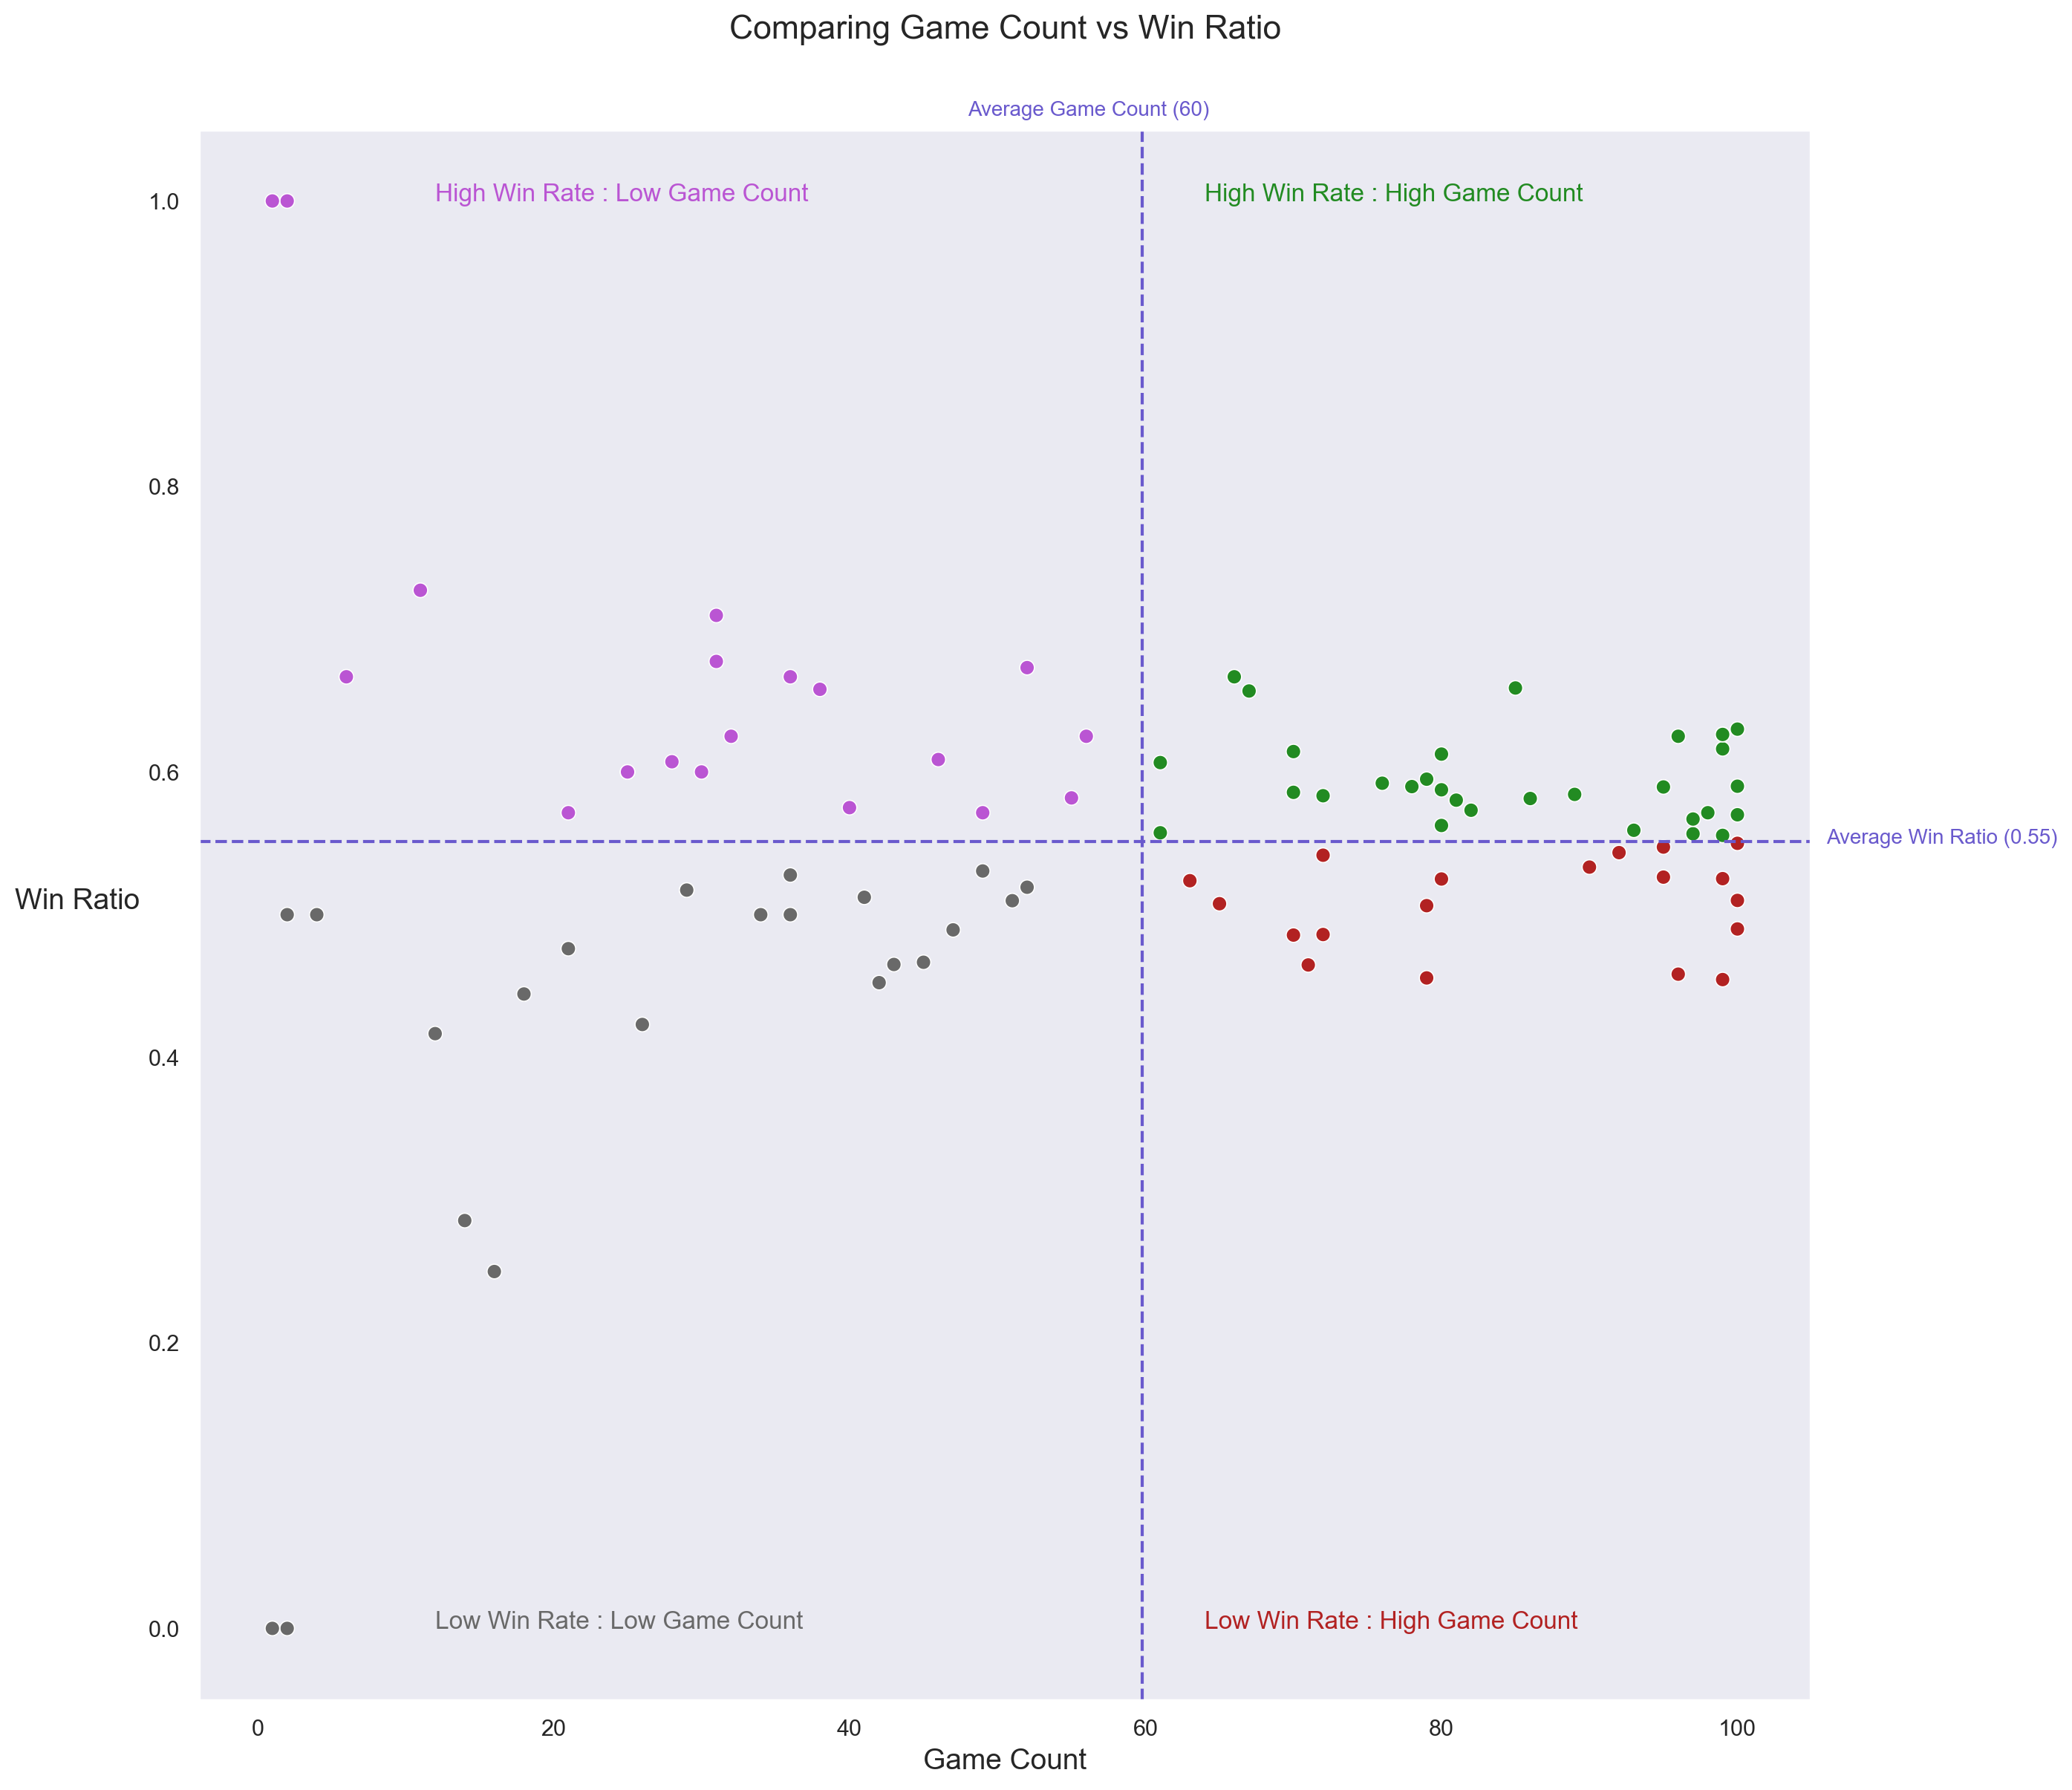

In [645]:
fig, ax = plt.subplots(figsize=(14,14), dpi = 200)


#plt.legend(bbox_to_anchor = (1.02, .8))
plt.title("Comparing Game Count vs Win Ratio", size = 16, y = 1.05)
plt.xlabel("Game Count", size = 14)
plt.ylabel("Win Ratio", size = 14, rotation = 0, horizontalalignment = "right")
ax.axhline(summoner_win_ratio["winRatio"].mean(), ls='--', c = "slateblue")
ax.axvline(summoner_win_ratio["gameCount"].mean(), ls='--', c = "slateblue")
ax.text(106,0.55, "Average Win Ratio (0.55)", c = "slateblue", size = 10)
ax.text(48, 1.06, "Average Game Count (60)", c = "slateblue", size = 10)

ax.text(12,1, "High Win Rate : Low Game Count", c = "mediumorchid", size = 12)
ax.text(64, 1, "High Win Rate : High Game Count", c = "forestgreen", size = 12)
ax.text(64,0, "Low Win Rate : High Game Count", c = "firebrick", size = 12)
ax.text(12,0, "Low Win Rate : Low Game Count", c = "dimgrey", size = 12)



colors = np.where((summoner_win_ratio["winRatio"] > summoner_win_ratio["winRatio"].mean()) &
                  (summoner_win_ratio["gameCount"] < summoner_win_ratio["gameCount"].mean()), "mediumorchid",
                 np.where((summoner_win_ratio["winRatio"] < summoner_win_ratio["winRatio"].mean()) &
                  (summoner_win_ratio["gameCount"] > summoner_win_ratio["gameCount"].mean()), "firebrick", np.where(
                  (summoner_win_ratio["winRatio"] > summoner_win_ratio["winRatio"].mean()) &
                  (summoner_win_ratio["gameCount"] > summoner_win_ratio["gameCount"].mean()), "forestgreen", "dimgrey")))
sns.set_style("dark")

sns.scatterplot(y = "winRatio", x = "gameCount", data = summoner_win_ratio, c = colors, s = 50)

plt.show()

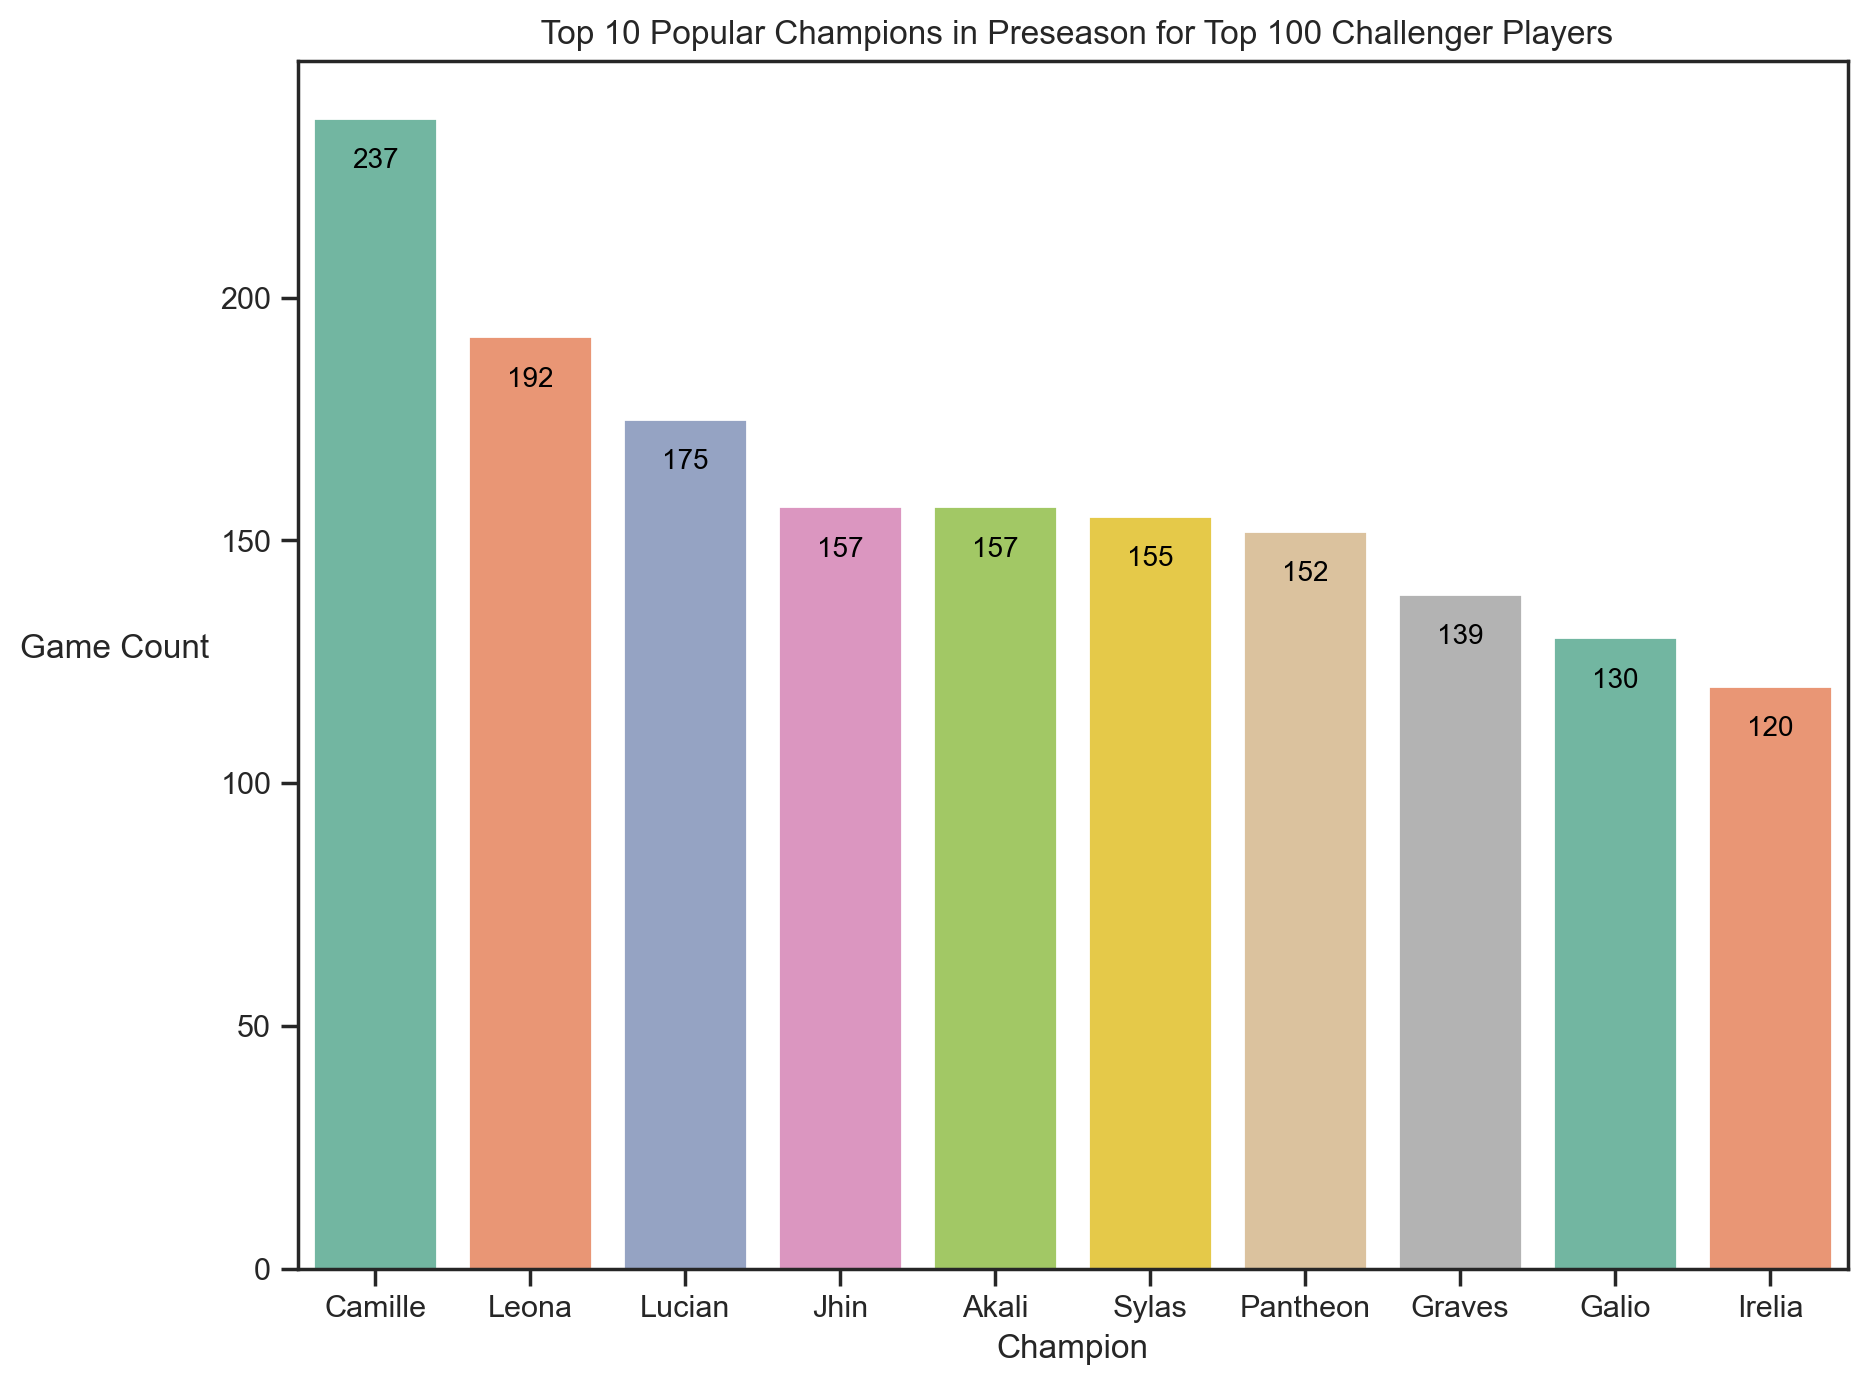

In [641]:
plt.figure(figsize = (10,8), dpi = 200)
sns.set(style = "ticks")
plt.title(" Top 10 Popular Champions in Preseason for Top 100 Challenger Players")
g = sns.barplot(x = "championName", y = "championCount", data = top_ten_win_rates, palette = "Set2")
plt.ylabel("Game Count", rotation = 0, horizontalalignment = "right")
plt.xlabel("Champion")

for p in g.patches:
    g.annotate(f'\n{round(p.get_height())}', (p.get_x() + 0.4, p.get_height()), ha='center', va='top', color='black', size=10)
plt.show()

In [75]:
game_count_by_champ = match_df.groupby("championName").agg({"gameID":"count"})
game_count_by_champ["gameID"].mean()

39.556338028169016

In [76]:
game_count_higher_than_average = game_count_by_champ.loc[game_count_by_champ["gameID"] >= 40, ]

In [77]:
game_count_higher_than_average = game_count_higher_than_average.reset_index()
game_count_higher_than_average.head

,championName,gameID
0,Akali,157
1,Alistar,71
2,Ashe,40
3,Bard,40
4,Caitlyn,45


In [675]:
champs_with_higher_than_avg_game_count = list(game_count_higher_than_average["championName"])

In [113]:
match_df_filtered = match_df.loc[match_df["championName"].isin(champs_with_higher_than_avg_game_count), ]

In [114]:
avg_kda_by_champ = match_df_filtered.groupby("championName").mean()[["kills", "deaths", "assists"]]

In [115]:
avg_kda_by_champ = avg_kda_by_champ.reset_index()

In [116]:
avg_kda_by_champ["killDeathRatio"] = avg_kda_by_champ["kills"] / avg_kda_by_champ["deaths"]

In [117]:
avg_kda_by_champ["assistDeathRatio"] = avg_kda_by_champ["assists"] / avg_kda_by_champ['deaths']

In [119]:
# top ten kill/death ratio champions
top_ten_kd_ratio = avg_kda_by_champ.sort_values(by = "killDeathRatio", ascending = False).head(10)

In [121]:
top_ten_kd_ratio

,championName,kills,deaths,assists,killDeathRatio,assistDeathRatio
13,Hecarim,8.929577,4.352113,9.014085,2.051780,2.071197
19,Kaisa,8.437500,4.187500,6.562500,2.014925,1.567164
22,Khazix,8.365079,4.206349,6.126984,1.988679,1.456604
12,Graves,7.561151,4.258993,7.503597,1.775338,1.761824
6,Ekko,7.793103,4.465517,7.034483,1.745174,1.575290
41,Riven,7.112150,4.224299,4.280374,1.683628,1.013274
34,Nidalee,7.451613,4.435484,7.177419,1.680000,1.618182
21,Kayn,7.509804,4.705882,8.156863,1.595833,1.733333
20,Kayle,7.816327,5.061224,6.795918,1.544355,1.342742
5,Camille,6.455696,4.223629,5.586498,1.528472,1.322677


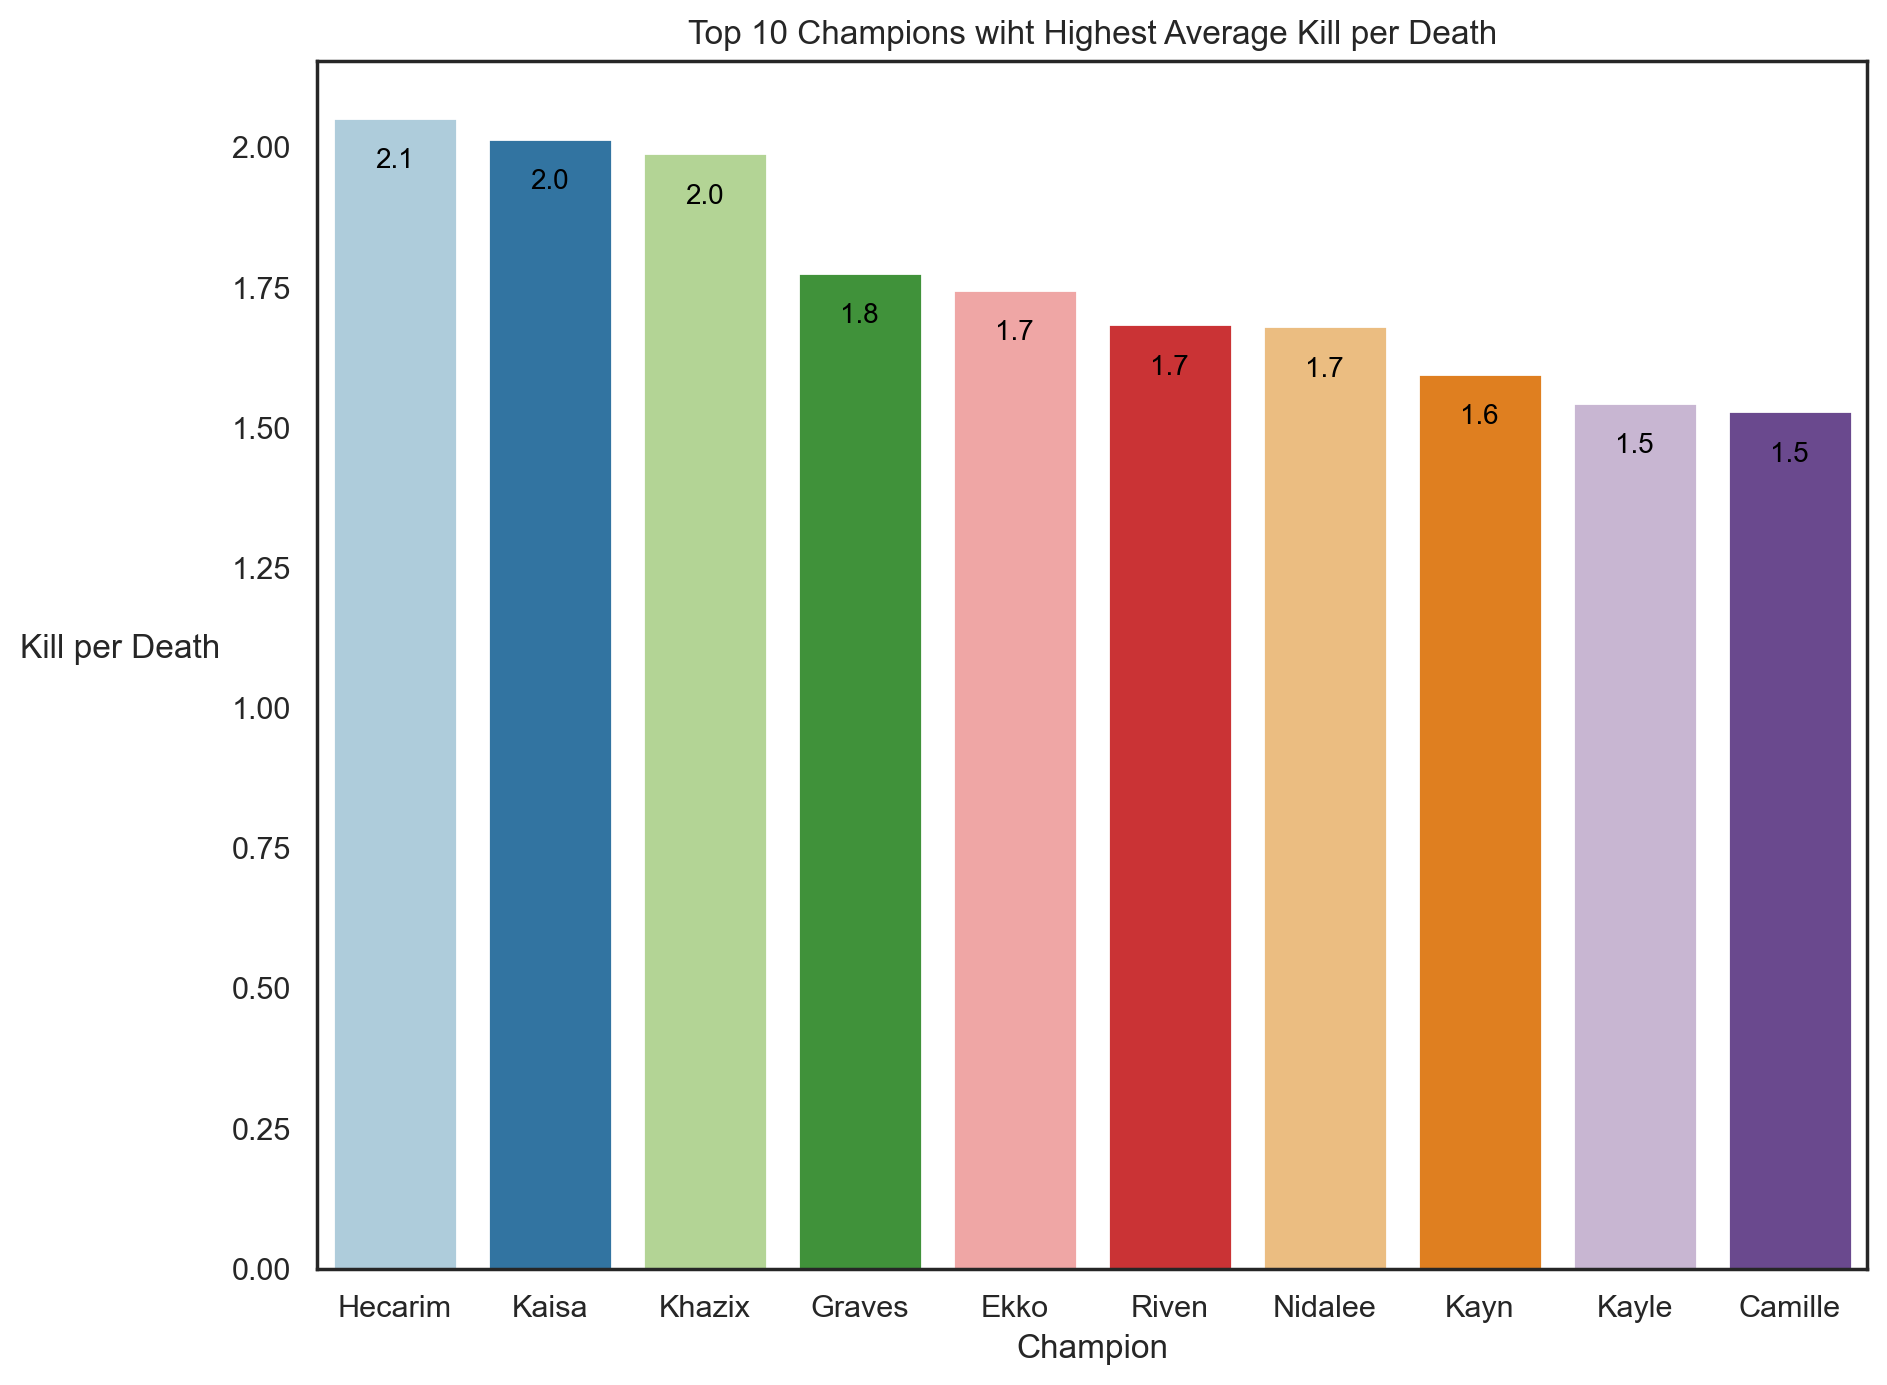

In [640]:
plt.figure(figsize = (10,8), dpi = 200)
g = sns.barplot(x = "championName", data = top_ten_kd_ratio, y = "killDeathRatio", palette = "Paired")
plt.ylabel("Kill per Death", horizontalalignment = "right", rotation = 0)
plt.xlabel("Champion")
plt.title("Top 10 Champions wiht Highest Average Kill per Death")

for p in g.patches:
    g.annotate(f'\n{round(p.get_height(),1)}', (p.get_x() + 0.4, p.get_height()), ha='center', va='top', color='black', size=10)
plt.show()

In [ ]:
plt.figure(figsize = (10,8), dpi = 200)
sns.barplot(x = "championName", data = top_ten_kd_ratio, y = "killDeathRatio")

In [128]:
# top ten assist/death ratio champions
top_ten_ad_ratio = avg_kda_by_champ.sort_values(by = "assistDeathRatio", ascending = False).head(10)

In [129]:
top_ten_ad_ratio

,championName,kills,deaths,assists,killDeathRatio,assistDeathRatio
32,Nami,2.722222,4.962963,16.962963,0.548507,3.417910
15,Janna,1.218750,4.656250,14.093750,0.261745,3.026846
35,Nunu,3.941176,4.691176,13.617647,0.840125,2.902821
1,Alistar,1.619718,4.915493,14.028169,0.329513,2.853868
39,Rakan,1.596774,4.354839,12.370968,0.366667,2.840741
47,Shen,3.283333,3.233333,8.916667,1.015464,2.757732
44,Senna,3.981132,3.867925,10.188679,1.029268,2.634146
9,Galio,4.453846,3.661538,9.292308,1.216387,2.537815
11,Gragas,5.057692,4.192308,10.596154,1.206422,2.527523
3,Bard,2.475000,5.425000,13.700000,0.456221,2.525346


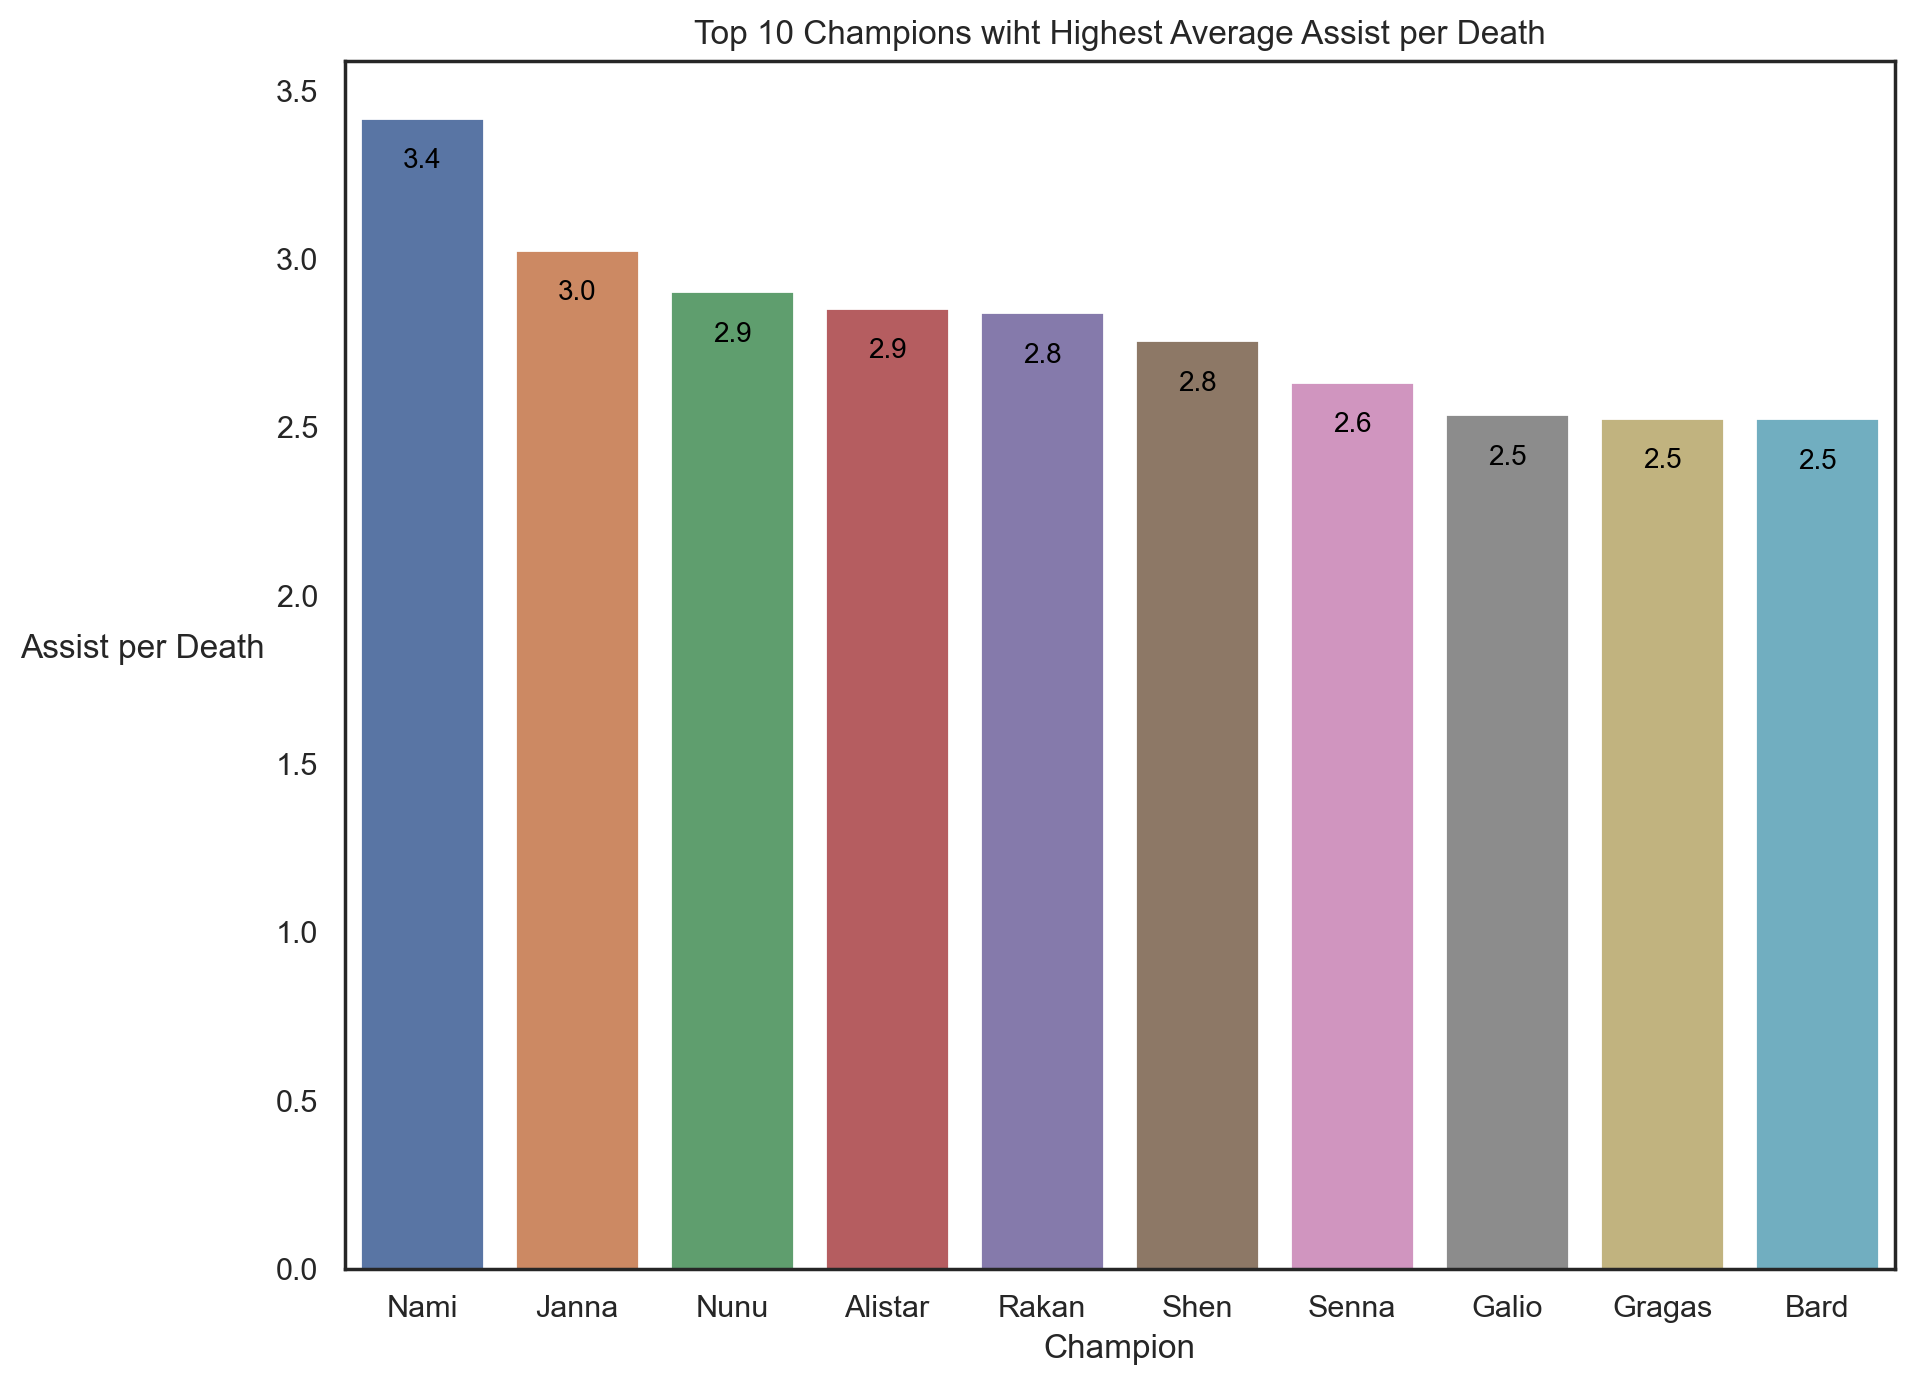

In [639]:
plt.figure(figsize = (10,8), dpi = 200)
g = sns.barplot(x = "championName", data = top_ten_ad_ratio, y = "assistDeathRatio")
plt.ylabel("Assist per Death",  horizontalalignment = "right", rotation = 0)
plt.xlabel("Champion")
plt.title("Top 10 Champions wiht Highest Average Assist per Death")


for p in g.patches:
    g.annotate(f'\n{round(p.get_height(),1)}', (p.get_x() + 0.4, p.get_height()), ha='center', va='top', color='black', size=10)

In [132]:
top_ten_kd_ratio.head()

,championName,kills,deaths,assists,killDeathRatio,assistDeathRatio
13,Hecarim,8.929577,4.352113,9.014085,2.051780,2.071197
19,Kaisa,8.437500,4.187500,6.562500,2.014925,1.567164
22,Khazix,8.365079,4.206349,6.126984,1.988679,1.456604
12,Graves,7.561151,4.258993,7.503597,1.775338,1.761824
6,Ekko,7.793103,4.465517,7.034483,1.745174,1.575290


In [135]:
top_ten_kd_champs = list(top_ten_kd_ratio["championName"])
match_df_top_kd_champs = match_df.loc[match_df["championName"].isin(top_ten_kd_champs)]

In [171]:
match_df_top_kd_champs = match_df_top_kd_champs.sort_values("totalDamageDealt", ascending = False)

In [285]:
champ_names = list(match_df_top_kd_champs["championName"].unique())

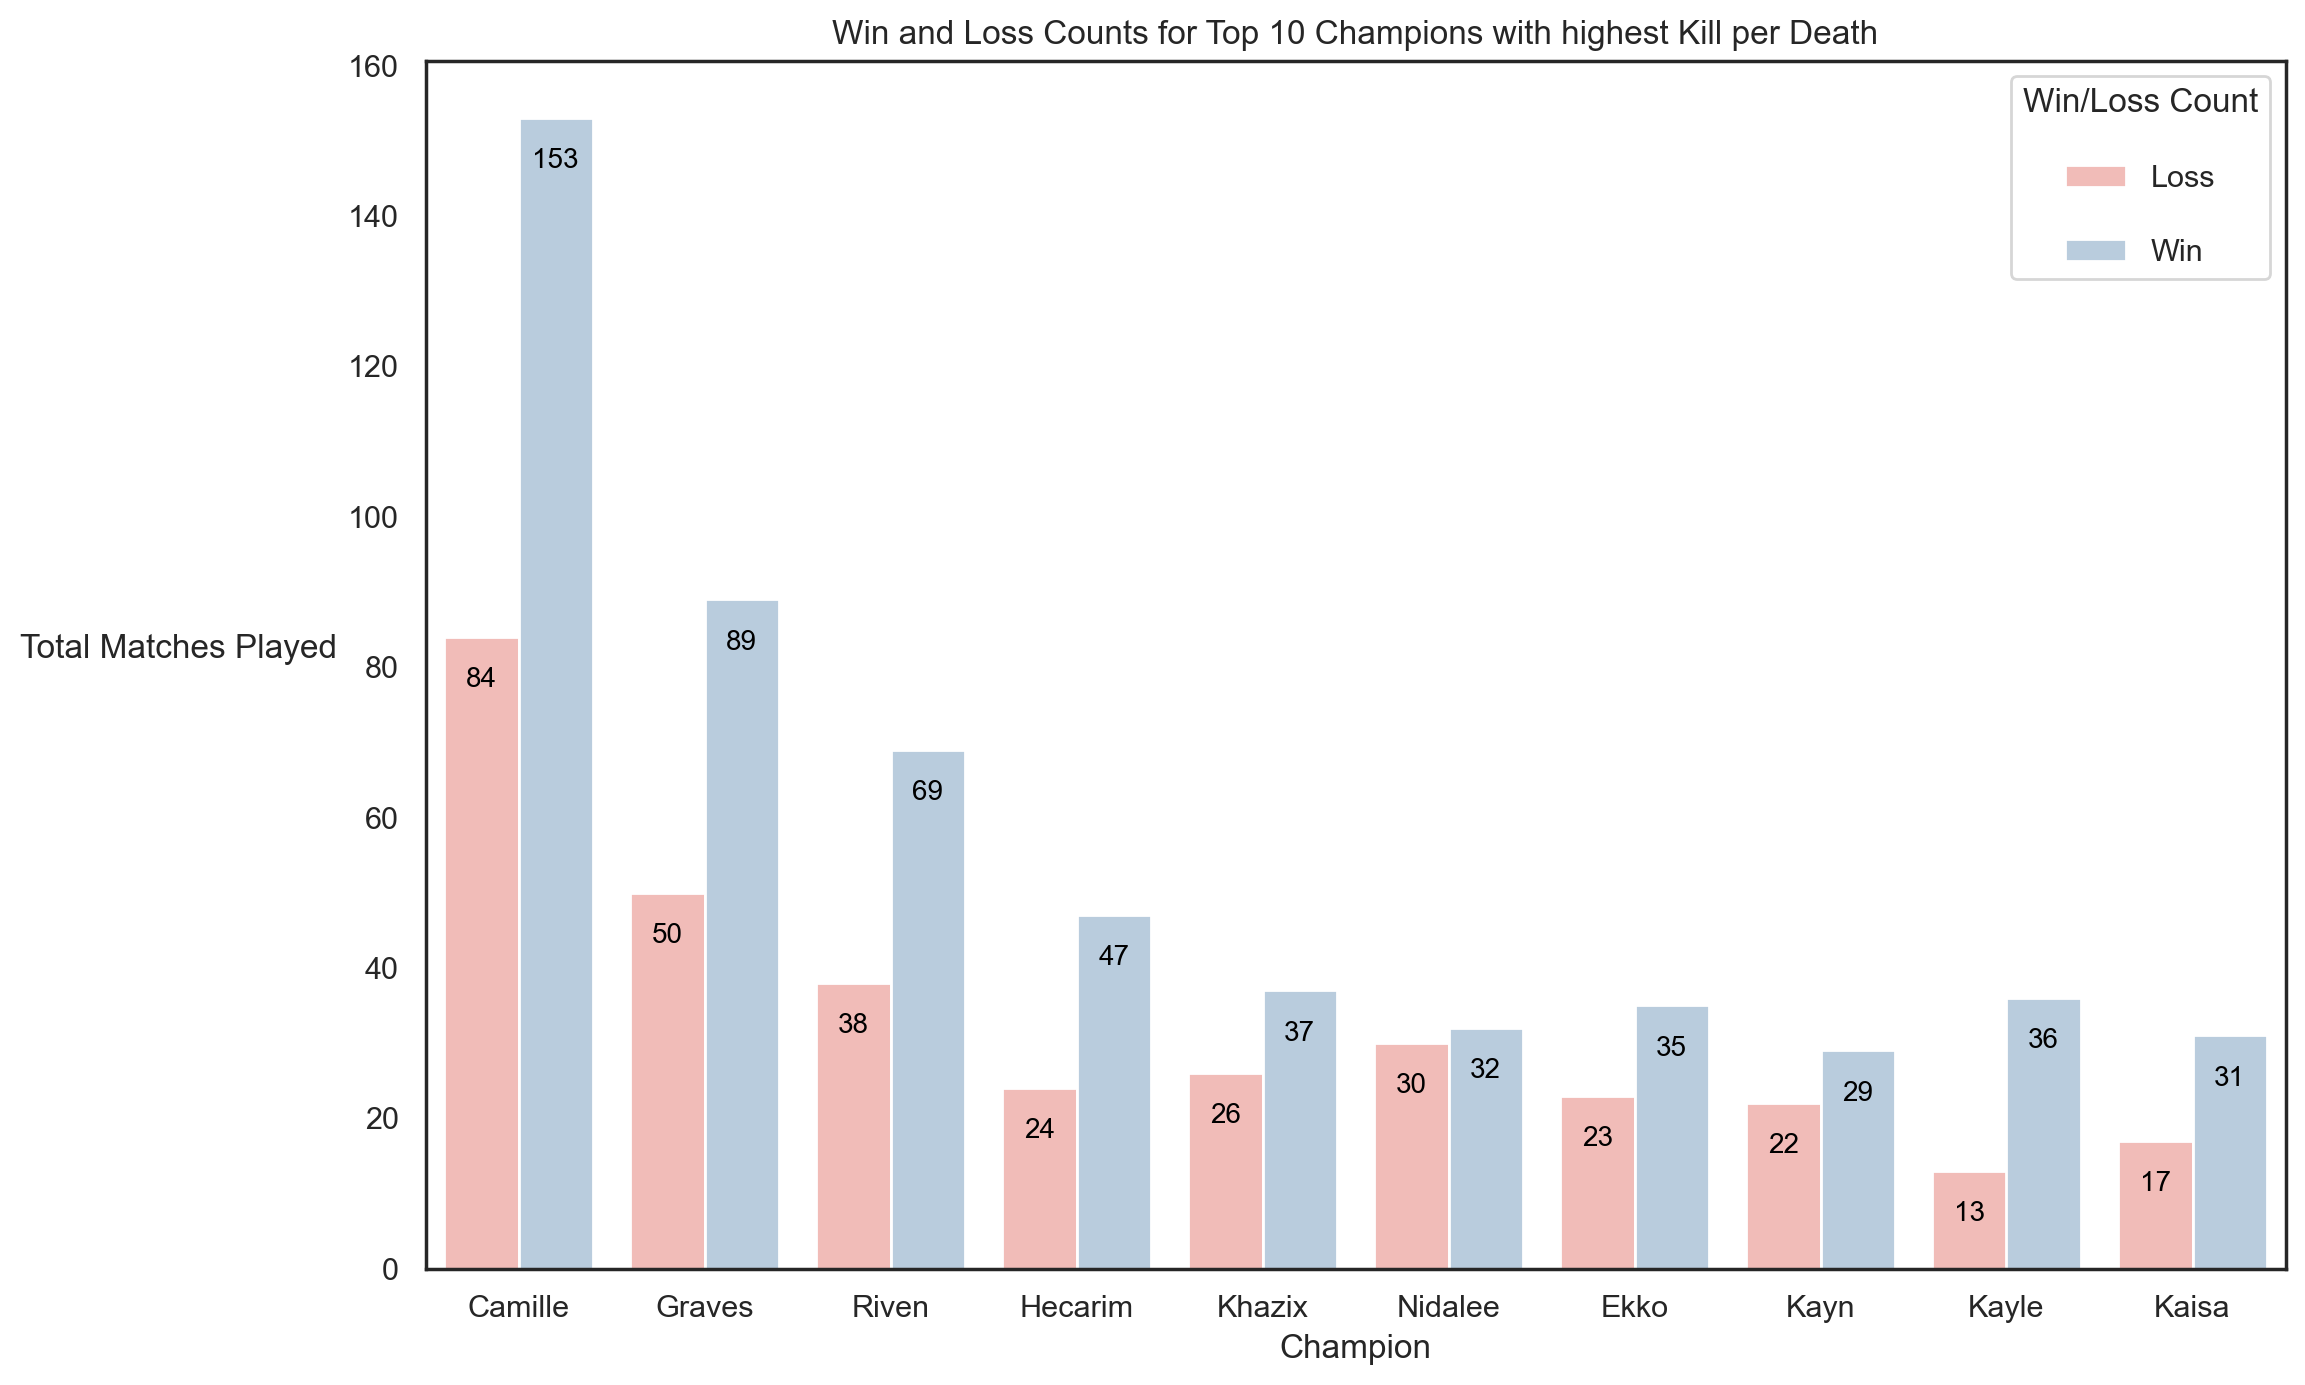

In [646]:
plt.figure(figsize=(12,8), dpi = 200)
sns.set(style = "white")
g = sns.countplot(data = match_df_top_kd_champs, x = "championName", hue = "win",  palette = "Pastel1", 
              order = match_df_top_kd_champs["championName"].value_counts().index)
plt.ylabel("Total Matches Played", rotation = 0, horizontalalignment = "right")
plt.xlabel("Champion")
plt.title("Win and Loss Counts for Top 10 Champions with highest Kill per Death")
plt.legend(labelspacing = 1.5, markerscale = 4, title = "Win/Loss Count", labels = ["Loss", "Win"])

for p in g.patches:
    g.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='black', size=10)

plt.show()